# Homework 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Task 1 Identify Features

### Assemble a dataset consisting of features and target (for example in a dataframe or in twoarrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection.

Let us load the two data files (each contain records of one class):

In [3]:
df_gen = pd.read_csv("data/OP_DTL_GNRL_PGYR2017_P01182019.csv")

/Users/arnaudstiegler/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_rch = pd.read_csv("data/OP_DTL_RSRCH_PGYR2017_P01182019.csv")

/Users/arnaudstiegler/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,5,7,8,9,10,12,15,17,18,19,20,21,22,23,24,25,30,32,35,37,38,42,43,44,45,47,48,49,50,51,52,53,54,55,56,59,60,61,62,67,68,69,70,71,72,73,74,75,76,79,80,81,87,88,89,90,91,92,93,94,95,96,99,100,101,107,108,109,110,111,112,113,114,115,116,119,120,121,129,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,160,161,162,163,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let us see how balanced the data is:

In [5]:
n_gen = df_gen.shape[0]
n_rch = df_rch.shape[0]
print(n_rch/n_gen)

0.05650219766194763


The data is **very imbalanced**! To deal with this imbalance upstream we will sample more of the minority class when making our dataset (we will aim at a 20/80 ratio to still keep some imbalance and be closer to the real-world context than a 50/50 split - albeit we are still very far from the actual 5/100 ratio)

We create the target variable:

In [6]:
df_gen['is_rch'] = 0

In [7]:
df_rch['is_rch'] = 1

**One way to start figuring one which variables leak information on the target is to see which variables appear in only one of the files - they are part of the leaking variables**. Such variables are:

In [8]:
in_gen_not_rch = set(df_gen.columns)-set(df_rch.columns)
in_rch_not_gen = set(df_rch.columns)-set(df_gen.columns)
in_both = set(df_gen.columns).intersection(set(df_rch.columns))

We sample from both datasets (10,000 records total), keeping only the columns they have in common:

In [9]:
df_gen = df_gen[list(in_both)]
df_rch = df_rch[list(in_both)]

In [10]:
df_gen = df_gen.sample(n=80000, random_state=0)
df_rch = df_rch.sample(n=20000, random_state=0)

In [11]:
df = pd.concat([df_gen, df_rch])

To (try to) free some memory:

In [12]:
del df_gen
del df_rch

### TEMP

In [13]:
df.to_csv("data/concatenated.csv", index=False)

In [3]:
df = pd.read_csv("data/concatenated.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,8,27,38,56,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### TEMP END

We shuffle records so that we don't have to worry about the ordering of the target variable later:

In [4]:
df = df.sample(frac=1, random_state=0)

In [5]:
working_df = df.copy()

In [7]:
working_df.shape

(10000, 65)

To reduce the set of predictors to choose from: we remove predictors that have more than 9,000 missing values (out of a little over 10,000 rows) - we might go back and fetch some of these later as `NA` values for categorical variable can carry a lot of information.

In [8]:
working_df = working_df.iloc[:,list(df.isna().sum() < 9*1e3)]

Columns `Payment_Publication_Date`, `Program_Year`, `Delay_in_Publication_Indicator` have only one value and so are completely uninformative for classification purposes.

Column `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name` (categorical) has 533 distinct value as well as formatting issues (same company can have different strings representing it). While we could use Bayesian target encoding to incorporate it in the model this would probably do more harm than good with information leakage. **With respect to our data size (10,000 rows for train+test) we probably can't afford to keep such variables that would make our data too high-dimensional with not enough data to capture the intricacies of the dimensions)**.

For similar reasons we will also remove `Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name`, `Recipient_Primary_Business_Street_Address_Line1`, `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID`, `Physician_Middle_Name`, `Physician_First_Name`, `Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2`, `Record_ID`, `Recipient_City`, `Recipient_Zip_Code`, `Physician_Last_Name`, `Physician_Profile_ID`, `Associated_Drug_or_Biological_NDC_2`, `Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1`, `Recipient_Primary_Business_Street_Address_Line2`, `Associated_Drug_or_Biological_NDC_1`, `Product_Category_or_Therapeutic_Area_1`, `Product_Category_or_Therapeutic_Area_2`

In [9]:
to_keep = ['Physician_License_State_code1',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
           'Related_Product_Indicator',
           'Physician_Primary_Type',
           'Form_of_Payment_or_Transfer_of_Value',
           'Change_Type',
           'Covered_or_Noncovered_Indicator_2',
           'Total_Amount_of_Payment_USDollars',
           'Recipient_State',
           'Date_of_Payment',
           'Physician_Specialty',
           'Covered_Recipient_Type',
           'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
           'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
           'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
           'Covered_or_Noncovered_Indicator_1',
           'Recipient_Country',
           'Dispute_Status_for_Publication',
           'is_rch']

In [10]:
working_df = working_df[to_keep]

In [11]:
working_df.columns

Index(['Physician_License_State_code1',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Physician_Primary_Type',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Date_of_Payment', 'Physician_Specialty', 'Covered_Recipient_Type',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Covered_or_Noncovered_Indicator_1', 'Recipient_Country',
       'Dispute_Status_for_Publication', 'is_rch'],
      dtype='object')

In [12]:
n_rows = working_df.shape[0]

We still have two variables that could be too obviously correlated: `Recipient_State` and `Physician_License_State_code1`. Indeed there are equal for the following proportion of rows:

In [13]:
(working_df['Recipient_State'] == working_df['Physician_License_State_code1']).sum() / n_rows

0.7109

This ratio is very high considering that there are 50 different possible values for each.

We will keep only `Recipient_State` (somewhat arbitrarily) for now and might go back an replace it with `Physician_License_State_code1` to see if the model performs better.

In [14]:
to_remove = ['Physician_License_State_code1']

To use `Date_of_Payment` we will extract information that can be useful for our models:

We create a feature: `Day_of_week_of_Payment`:

In [15]:
working_df['Date_of_Payment'] = pd.to_datetime(working_df['Date_of_Payment'])
working_df['Day_of_week_of_Payment'] = working_df['Date_of_Payment'].dt.day_name()

As well as an indicator variable `Week_or_weekend_Payment` (1 for a weekday and 0 for the weekend):

In [16]:
def weekend_map(row):
    if row['Day_of_week_of_Payment'] == 'Saturday':  
        return 1
    elif row['Day_of_week_of_Payment'] == 'Sunday':
        return 1
    else:
        return 0
    
working_df['Week_or_weekend_Payment'] = working_df.apply(weekend_map, axis=1).astype(object)

We also extract the day of the month (`Day_of_month_of_Payment`) as well as the month (`Month_of_Payment`):

In [17]:
working_df['Day_of_month_of_Payment'] = working_df['Date_of_Payment'].dt.day.astype(object)
working_df['Month_of_Payment'] = working_df['Date_of_Payment'].dt.month.astype(object)

And we get rid of the raw date.

In [18]:
working_df = working_df.drop('Date_of_Payment', axis=1)

We also need to extract information from `Physician_Specialty` in which specialties are separated by `|`. We extract the values in three new columns.

In [19]:
working_df[['Physician_Specialty_1', 
    'Physician_Specialty_2', 
    'Physician_Specialty_3']] = working_df['Physician_Specialty'].str.split('|', expand=True)

It seems like specialties are getting more specific from `Physician_Specialty_1` to `Physician_Specialty_3`:

In [20]:
len(working_df['Physician_Specialty_1'].unique())

11

In [21]:
len(working_df['Physician_Specialty_2'].unique())

43

In [22]:
len(working_df['Physician_Specialty_3'].unique())

118

Only `Physician_Specialty_1` and maybe `Physician_Specialty_2` seem like manageable-sized categorical variable so we will keep only these (and might have to drop `Physician_Specialty_2` later):

In [23]:
to_remove.append('Physician_Specialty_3')
to_remove.append('Physician_Specialty')

We also have two variables that may deliver redundant information: `Covered_Recipient_Type`, `Covered_or_Noncovered_Indicator_1`

In [25]:
((working_df['Covered_Recipient_Type'] == 'Non-covered Recipient Entity') 
 == (working_df['Covered_or_Noncovered_Indicator_1'] == 'Non-covered')).sum() / n_rows

0.8383

The category 'Non-covered Recipient Entity' is strongly correlated with 'Non-covered' as expected and they represent the majority of records. We will keep only `Covered_Recipient_Type` that is more fine-grained and might deliver more valuable (we hope) information.

In [26]:
to_remove.append('Covered_or_Noncovered_Indicator_1')

We remove those few variables we decided to take out and look at the shape of our data now:

In [27]:
working_df = working_df.drop(columns=to_remove)
print(working_df.shape)

(10000, 21)


Our data is pretty tall as of now but we expect to grow much wider after one-hot-encoding of some categorical variables.

**Now that we have some promising candidates for our features, let us now observe how some variables are related to the target to justify keeping or dropping them**:

In [28]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Related_Product_Indicator', 'Physician_Primary_Type',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Covered_Recipient_Type',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Recipient_Country', 'Dispute_Status_for_Publication', 'is_rch',
       'Day_of_week_of_Payment', 'Week_or_weekend_Payment',
       'Day_of_month_of_Payment', 'Month_of_Payment', 'Physician_Specialty_1',
       'Physician_Specialty_2'],
      dtype='object')

*Let us now look at the distribution of the predictors and how it varies with values of the target variable:*

- `Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country` 

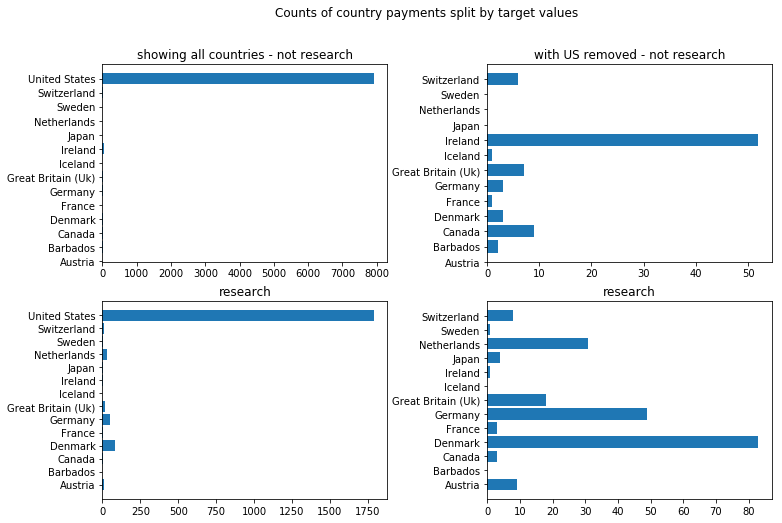

In [29]:
temp = working_df.groupby(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 
                   'is_rch'])['is_rch'].count()
temp = temp.unstack(1)
temp.index.name = "countries"

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Counts of country payments split by target values")

ax[0, 0].barh(y=temp.index, width=temp[0])
ax[0, 0].set_title("showing all countries - not research")

ax[1, 0].barh(y=temp.index, width=temp[1])
ax[1, 0].set_title("research")

temp = temp.drop('United States', axis=0)

ax[0, 1].barh(y=temp.index, width=temp[0])
ax[0, 1].set_title("with US removed - not research")

ax[1, 1].barh(y=temp.index, width=temp[1])
ax[1, 1].set_title("research")

fig.subplots_adjust(wspace=.35)

Above are bar charts of counts of each payment split across values of the target (research/not research) horizontally, and with and without the US included to gain more insight on the full distribution. **Looking at these plots we see that the distribution across countries outside of the US is very different between research and non-research payments. This suggests that the predictor might be helpful to predict the target but only rather for the payments outside of the US - a minority of payments. Since a large majority of payments are made from the US, this predictor is certainly not sufficient to explain the target on its own.**

- `Form_of_Payment_or_Transfer_of_Value`

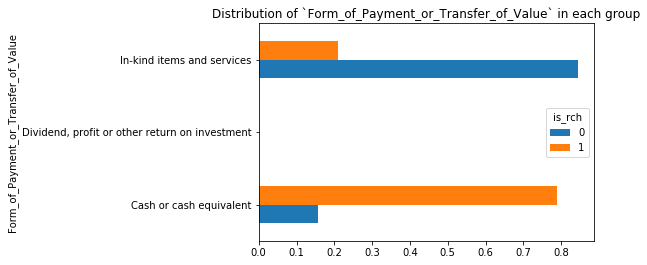

In [30]:
temp = working_df.groupby(['Form_of_Payment_or_Transfer_of_Value', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='barh', title="Distribution of `Form_of_Payment_or_Transfer_of_Value` in each group")

**This feature seems particularly valuable in predicting if a payment is a research one or not!**

- `Total_Amount_of_Payment_USDollars`

In [31]:
working_df1 = working_df[working_df['is_rch'] == 0]
working_df2 = working_df[working_df['is_rch'] == 1]

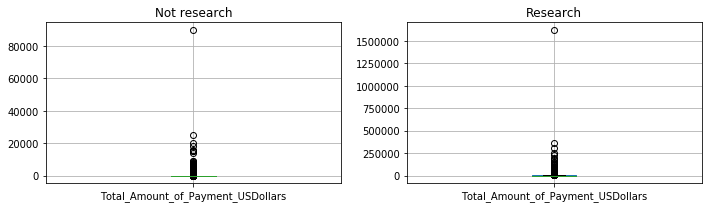

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Not research')
ax[1].set_title('Research')
working_df1.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[0])
working_df2.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[1])
fig.tight_layout()

These boxplots show two very strong outliers, one for each target value. **Should we decide to keep this variable as a feature, we will need to remove those observations altogether as they risk distorting our predictions significantly**. Let us filter the bulk of outliers out and look at the distribution again:

In [33]:
working_df1 = working_df1[working_df1['Total_Amount_of_Payment_USDollars'] < 40000]
working_df2 = working_df2[working_df2['Total_Amount_of_Payment_USDollars'] < 40000]

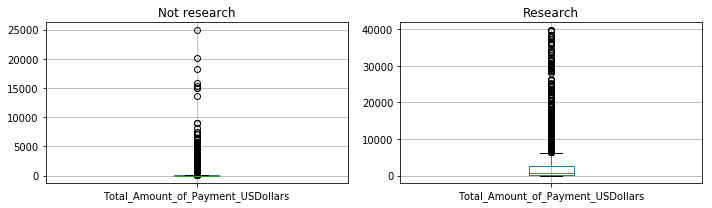

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].set_title('Not research')
ax[1].set_title('Research')
working_df1.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[0])
working_df2.boxplot(column=['Total_Amount_of_Payment_USDollars'], ax=ax[1])
fig.tight_layout()

Both distributions are concentrated around low values of the payments (low compared to the possible range of payments found in the data) but seem significantly different, with research grants densely populated with outliers. **This variable seems like a potentially useful predictor**.

As previously mentioned, we need to get rid of the two extreme outliers:

In [35]:
working_df = working_df[working_df['Total_Amount_of_Payment_USDollars'] < 80000]

- `Related_Product_Indicator`

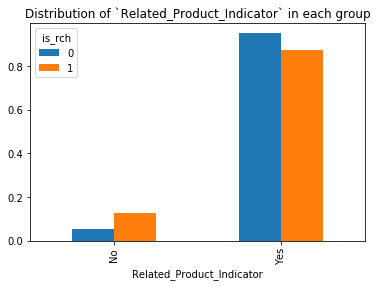

In [36]:
temp = working_df.groupby(['Related_Product_Indicator', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='bar', title="Distribution of `Related_Product_Indicator` in each group")

This plot shows that the distribution of `Related_Product_Indicator` is a little different conditional on the values of `is_rch`. There are more than 10 times more `Yes` than `No` conditional on `is_rch = 0` and about only 6 times more `Yes` than `No` conditional on `is_rch = 1`. This feature might be useful to predict `is_rch` but perhaps not very significantly so we'll drop it for now.

In [37]:
to_remove = ['Related_Product_Indicator']

- `Physician_Primary_Type`

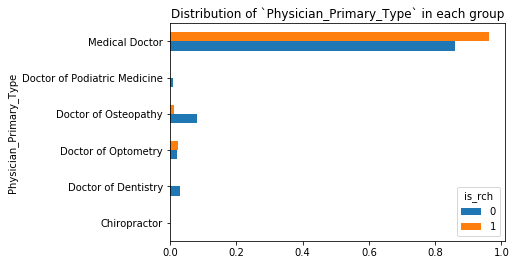

In [38]:
temp = working_df.groupby(['Physician_Primary_Type', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='barh', title="Distribution of `Physician_Primary_Type` in each group")

Similar conclusion as the last feature.

In [39]:
to_remove.append('Physician_Primary_Type')

Variable `Covered_Recipient_Type` **leaks too much information on the target** (see below) so we will also remove it:

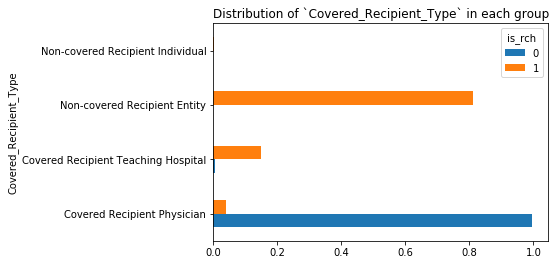

In [40]:
temp = working_df.groupby(['Covered_Recipient_Type', 'is_rch'])['is_rch'].count().unstack(1)
temp[0] = temp[0]/temp[0].sum()
temp[1] = temp[1]/temp[1].sum()
temp.plot(kind='barh', title="Distribution of `Covered_Recipient_Type` in each group")

In [41]:
to_remove.append('Covered_Recipient_Type')

The two following variables have only one value across the dataset so we discard them as well:

In [42]:
to_remove.append('Recipient_Country')
to_remove.append('Dispute_Status_for_Publication')

We keep the other variables that are potentially informative. The final features are as follows:

In [43]:
working_df = working_df.drop(columns=to_remove)

In [44]:
working_df.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'is_rch',
       'Day_of_week_of_Payment', 'Week_or_weekend_Payment',
       'Day_of_month_of_Payment', 'Month_of_Payment', 'Physician_Specialty_1',
       'Physician_Specialty_2'],
      dtype='object')

## Task 2 Preprocessing and Baseline Model

### Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset.

We are going to create an initial model with the features that we selected in **Task 1**.

The only continuous feature we have is `Total_Amount_of_Payment_USDollars`.

In [45]:
cont = ['Total_Amount_of_Payment_USDollars']
cat = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value',
       'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Day_of_week_of_Payment',
       'Week_or_weekend_Payment',
       'Day_of_month_of_Payment',
       'Month_of_Payment',
       'Physician_Specialty_1',
       'Physician_Specialty_2']

We check if we have missing values:

In [48]:
working_df.isna().any()

Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country    False
Form_of_Payment_or_Transfer_of_Value                                False
Change_Type                                                         False
Covered_or_Noncovered_Indicator_2                                   False
Total_Amount_of_Payment_USDollars                                   False
Recipient_State                                                     False
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2           False
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State      False
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           False
is_rch                                                              False
Day_of_week_of_Payment                                              False
Week_or_weekend_Payment                                             False
Day_of_month_of_Payment                                             False
Month_of_Payment                      

Missing values appear only in categorical variables. We will create a category for them for the 4 variables that have them (for both train and test data):

In [47]:
working_df = working_df.replace(to_replace={var:np.NaN for var in cat}, 
                                value="N/A")

**We can now split the data into training and test and only work with the training data, using the test data for performance measurement only**

In [49]:
y = working_df['is_rch']
working_df = working_df.drop(columns=['is_rch'])

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train, test, y_train, y_test = train_test_split(working_df, 
                                                y, test_size=.2, 
                                                random_state=0, 
                                                stratify=y)

We will now **randomly select 4 out of the 14 categorical features** and add the continuous feature to build our baseline model on:

In [52]:
np.random.seed(20190302)

In [53]:
rand = np.random.choice(range(15), size=11, replace=False)
train_col_sample = train.drop(columns=train.columns[rand], axis=1)
train_col_sample['Total_Amount_of_Payment_USDollars'] = train['Total_Amount_of_Payment_USDollars']

In [54]:
train_col_sample.columns

Index(['Change_Type', 'Covered_or_Noncovered_Indicator_2',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Month_of_Payment', 'Total_Amount_of_Payment_USDollars'],
      dtype='object')

In [55]:
cat_col_sample = ['Change_Type',
                  'Covered_or_Noncovered_Indicator_2',
                  'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
                  'Month_of_Payment']

As we observed many outliers in `Total_Amount_of_Payment_USDollars` we will use a **robust scaler** for preprocessing. We will **one-hot encode** all other variables. Finally we will fit a **logistic regression** with default parameters and evaluate it with a **10 fold cross-validation** - looking at **average precision and ROC-AUC** (particularly adapted to imbalanced data such as here).

In [56]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [57]:
encoder = OneHotEncoder(categories=[[*working_df[var].unique(), "N/A"] for var in cat_col_sample])
preprocess = make_column_transformer((RobustScaler(), cont), 
                                     (encoder, cat_col_sample))
baseline = make_pipeline(preprocess, LogisticRegression(solver='saga', penalty='l1',
                                                        max_iter=1e4))

In [58]:
scores = cross_validate(baseline, train_col_sample, y_train, cv=10,
                        scoring=("roc_auc", "average_precision"))

The **validation scores** are:

In [59]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.8507202756942833, 0.668822726035631)

The **test scores** are:

In [60]:
baseline = baseline.fit(train_col_sample, y_train)

In [61]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [62]:
baseline_ap = average_precision_score(y_test, baseline.predict_proba(test)[:, 1])
baseline_ra = roc_auc_score(y_test, baseline.predict_proba(test)[:, 1])

In [63]:
baseline_ra, baseline_ap

(0.8605137310606061, 0.7080724783478067)

We plot the **PR and ROC curves** on the **test set** to gain more insight on the model performance:

In [64]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, baseline.predict_proba(test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, baseline.predict_proba(test)[:, 1])

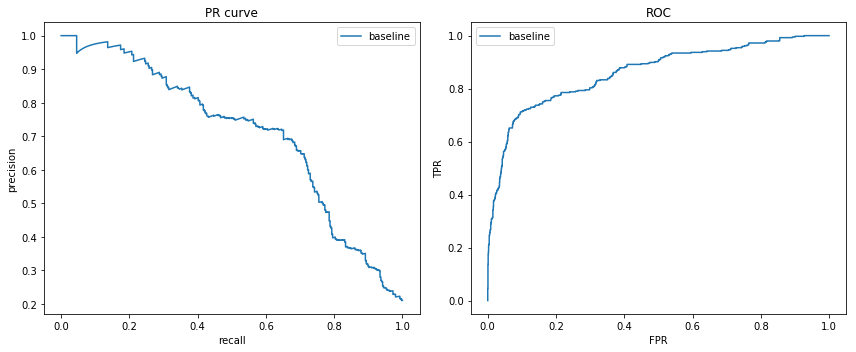

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

## Task 3 Feature Engineering

### Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

Let us look at the features we have extracted so far:

In [67]:
train.columns

Index(['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Form_of_Payment_or_Transfer_of_Value', 'Change_Type',
       'Covered_or_Noncovered_Indicator_2',
       'Total_Amount_of_Payment_USDollars', 'Recipient_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
       'Day_of_week_of_Payment', 'Week_or_weekend_Payment',
       'Day_of_month_of_Payment', 'Month_of_Payment', 'Physician_Specialty_1',
       'Physician_Specialty_2'],
      dtype='object')

And those among the above that were used in the baseline:

In [68]:
train_col_sample.columns

Index(['Change_Type', 'Covered_or_Noncovered_Indicator_2',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2',
       'Month_of_Payment', 'Total_Amount_of_Payment_USDollars'],
      dtype='object')

**Among these we derived `Day_of_month_of_Payment`, `Day_of_week_of_Payment`, `Month_of_Payment` and `Week_or_weekend_Payment` from the original `Date_of_Payment`.**

**We also extracted `Physician_Specialty_1` and `Physician_Specialty_2` from the original `Physician_Specialty`.**

We add **another new feature (`Physician_Payment_Counts`)**: the number of payments to the physician of each payment. **We also make sure that we don't leak information from the test set into the train set by using only the training data to compute our feature.**

In [69]:
# we make sure we filter the outliers out before assigning the id column
temp_df = df[df['Total_Amount_of_Payment_USDollars'] < 80000]
working_df['Physician_Profile_ID'] = df['Physician_Profile_ID']

In [70]:
# we re-do the split, the random seed guarantees we will have the
# the same records in both train and test as before,
# with the added physician id
train, test, y_train, y_test = train_test_split(working_df, 
                                                y, test_size=.2, 
                                                random_state=0, 
                                                stratify=y)

In [71]:
temp = train[['Physician_Profile_ID']].groupby(['Physician_Profile_ID']).size().reset_index(name='Physician_Payment_Counts')

In [72]:
# make sure we don't mess with the index and the order of the rows
train = train.reset_index().merge(temp, how='left', on='Physician_Profile_ID').set_index('index')
test = test.reset_index().merge(temp, how='left', on='Physician_Profile_ID').set_index('index')

train['Physician_Payment_Counts'] = train['Physician_Payment_Counts'].astype(object)
test['Physician_Payment_Counts'] = test['Physician_Payment_Counts'].astype(object)

train = train.replace(to_replace={'Physician_Payment_Counts':np.NaN}, 
                      value="0")
test = test.replace(to_replace={'Physician_Payment_Counts':np.NaN}, 
                    value="0")

train = train.drop(columns='Physician_Profile_ID')
test = test.drop(columns='Physician_Profile_ID')

**Let us now add some variables we constructed from the data to our baseline model training data and look at its performance again.** (we need to do a little reprocessing again with the new added feature, and because we re-fetched train and test from the dataframe before the following preprocessing was done). We add our other newest feature to the categorical variables (it has only three levels so we believe it is better to consider it as categorical especially since it is skewed and a robust scaler might be ill-fitting)

In [73]:
cat.append('Physician_Payment_Counts')

Adding our own features and one more existing feature:

In [74]:
train_col_sample['Day_of_month_of_Payment'] = train['Day_of_month_of_Payment']
train_col_sample['Day_of_week_of_Payment'] = train['Day_of_week_of_Payment']
train_col_sample['Week_or_weekend_Payment'] = train['Week_or_weekend_Payment']
train_col_sample['Physician_Payment_Counts'] = train['Physician_Payment_Counts']
train_col_sample['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1'] = train['Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1']

In [75]:
cat_col_sample.append('Day_of_month_of_Payment')
cat_col_sample.append('Day_of_week_of_Payment')
cat_col_sample.append('Week_or_weekend_Payment')
cat_col_sample.append('Physician_Payment_Counts')
cat_col_sample.append('Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1')

In [76]:
encoder = OneHotEncoder(categories=[[*train[var].unique(), "N/A"] for var in cat_col_sample])
preprocess = make_column_transformer((RobustScaler(), cont), 
                                     (encoder, cat_col_sample))
baseline_improved = make_pipeline(preprocess, LogisticRegression(solver='saga', penalty='l1',
                                                                 max_iter=1e4))

In [77]:
scores_2 = cross_validate(baseline_improved, train_col_sample, y_train, cv=10,
                          scoring=("roc_auc", "average_precision"))

The **validation scores** are:

In [78]:
scores_2['test_roc_auc'].mean(), scores_2['test_average_precision'].mean()

(0.9889735215972346, 0.9711627274877317)

The **test scores** are:

In [79]:
baseline_improved = baseline_improved.fit(train_col_sample, y_train)

In [80]:
baseline_imp_ap = average_precision_score(y_test, baseline_improved.predict_proba(test)[:, 1])
baseline_imp_ra = roc_auc_score(y_test, baseline_improved.predict_proba(test)[:, 1])

In [81]:
baseline_imp_ra, baseline_imp_ap

(0.8647253787878788, 0.6757912394789671)

The baseline test scores were:

In [82]:
baseline_ra, baseline_ap

(0.8605137310606061, 0.7080724783478067)

**These metrics don't show enough of an improvement to justify adding the features**. Let us look at the PR and ROC curves:

In [83]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test, baseline_improved.predict_proba(test)[:, 1])
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, baseline_improved.predict_proba(test)[:, 1])

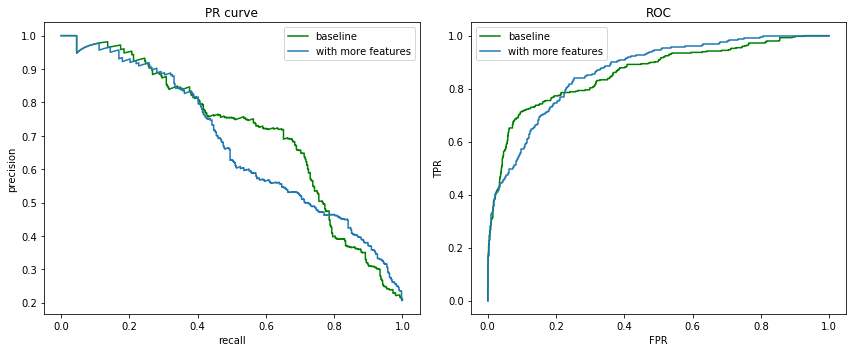

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, color ='g', label='baseline')
ax[0].plot(recall_2, precision_2, label='with more features')
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc='best')

ax[1].plot(fpr, tpr, color='g', label='baseline')
ax[1].plot(fpr_2, tpr_2, label='with more features')
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc='best')

fig.tight_layout()

Now the curves tell a different story: let us remember that we are working with imbalanced classes (the proportion of research payments is much smaller than that of non-research payments). Recall, or the ability to correctly cover the minority class, is often important in such cases. 

Let us now give a context to our classification problem: this will enable us to choose models with a goal in mind, rather than just broadly compare different metrics and pick the one that looks best on average.

Let us say that we want to classify payments so that we can more easily investigate research payments to see if they were fraudulous. With this goal in mind, we would prefer all research payments to be identified, with a small cost associated to a general payment identified as a research payment. On the other hand, identifying a research payment as a general one makes us unable to investigate it and a fraudulous payment might slip through: this has a higher cost.

**Therefore we would like our model's coverage (or recall) to be high.**

**To compare both models on the basis of this goal we need to look at high recall (TPR) areas on the curves.** The model with added features' curves are higher than the baseline's by quite a margin for recalls of 0.8 and larger. It would seem that adding engineered features served our goal. Should we stop here we would probably go with the newer model. The gain is not significant enough to stop here however.

In [481]:
# other ways to encode categorical variables???

## Task 4 Any model

### Use any classification model we discussed (trees, forests, gradient boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate.